In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

import os

from scipy import interpolate
from scipy.signal import savgol_filter as savgol

import librosa
from librosa.util import normalize as norm
from librosa.core import get_duration

6.688771963119507


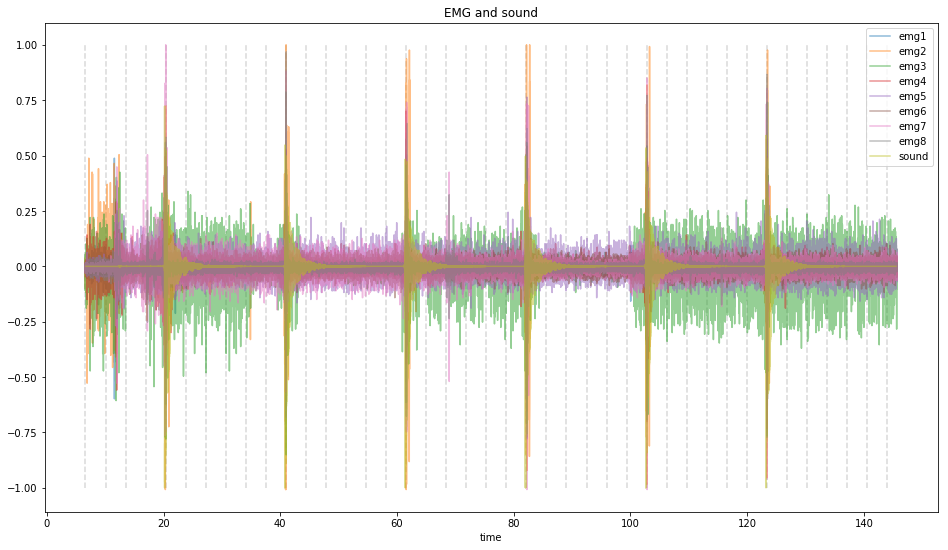

In [ ]:
myos = {"m7": "d0-8d-fc-7f-f5-f1",
        "mc": "d9-db-d4-2b-d4-17",
        "m8": "ef-9d-fd-31-ea-10"}

names = ['cagri', 'kjell', 'gui', 'qichao']

tasks = ['sustained_soft_70',
         'sustained_strong_70',
         'iterative_soft_70',
         'iterative_strong_70']

# mac = macs[0]
task = tasks[1]
name = names[0]
path = os.path.join("../data", name, task,'')
emg_l = pd.read_csv(path + 'emg_' + myos["m7"] + '.csv', index_col=0)
emg_r = pd.read_csv(path + 'emg_' + myos["mc"] + '.csv', index_col=0)

emg_l.index.name, emg_r.index.name = 'time', 'time'

sound, sr = librosa.load(path + task +'.wav', sr=48000)

file = open(path + 'timeline.txt', 'r')
metro_timeline = file.read().split(',')
metro_timeline = [float(i) for i in metro_timeline]
file.close()

file = open(path + 'audio_start.txt', 'r')
start = float(file.read())
file.close
print(start)

time = np.linspace(start, start + get_duration(sound, sr=48000), num=len(sound) )

plt.figure(figsize=(16,9))
plt.title('EMG and sound')
plt.xlabel("time")

for col in emg_r:
    plt.plot(emg_r.index, emg_r[col], label=col, alpha=0.5)
plt.plot(time, sound, label="sound", alpha=0.5)
plt.vlines(metro_timeline[::4], -1, 1, colors = "grey", linestyles = "dashed", alpha=0.3)
plt.legend(loc='upper right')

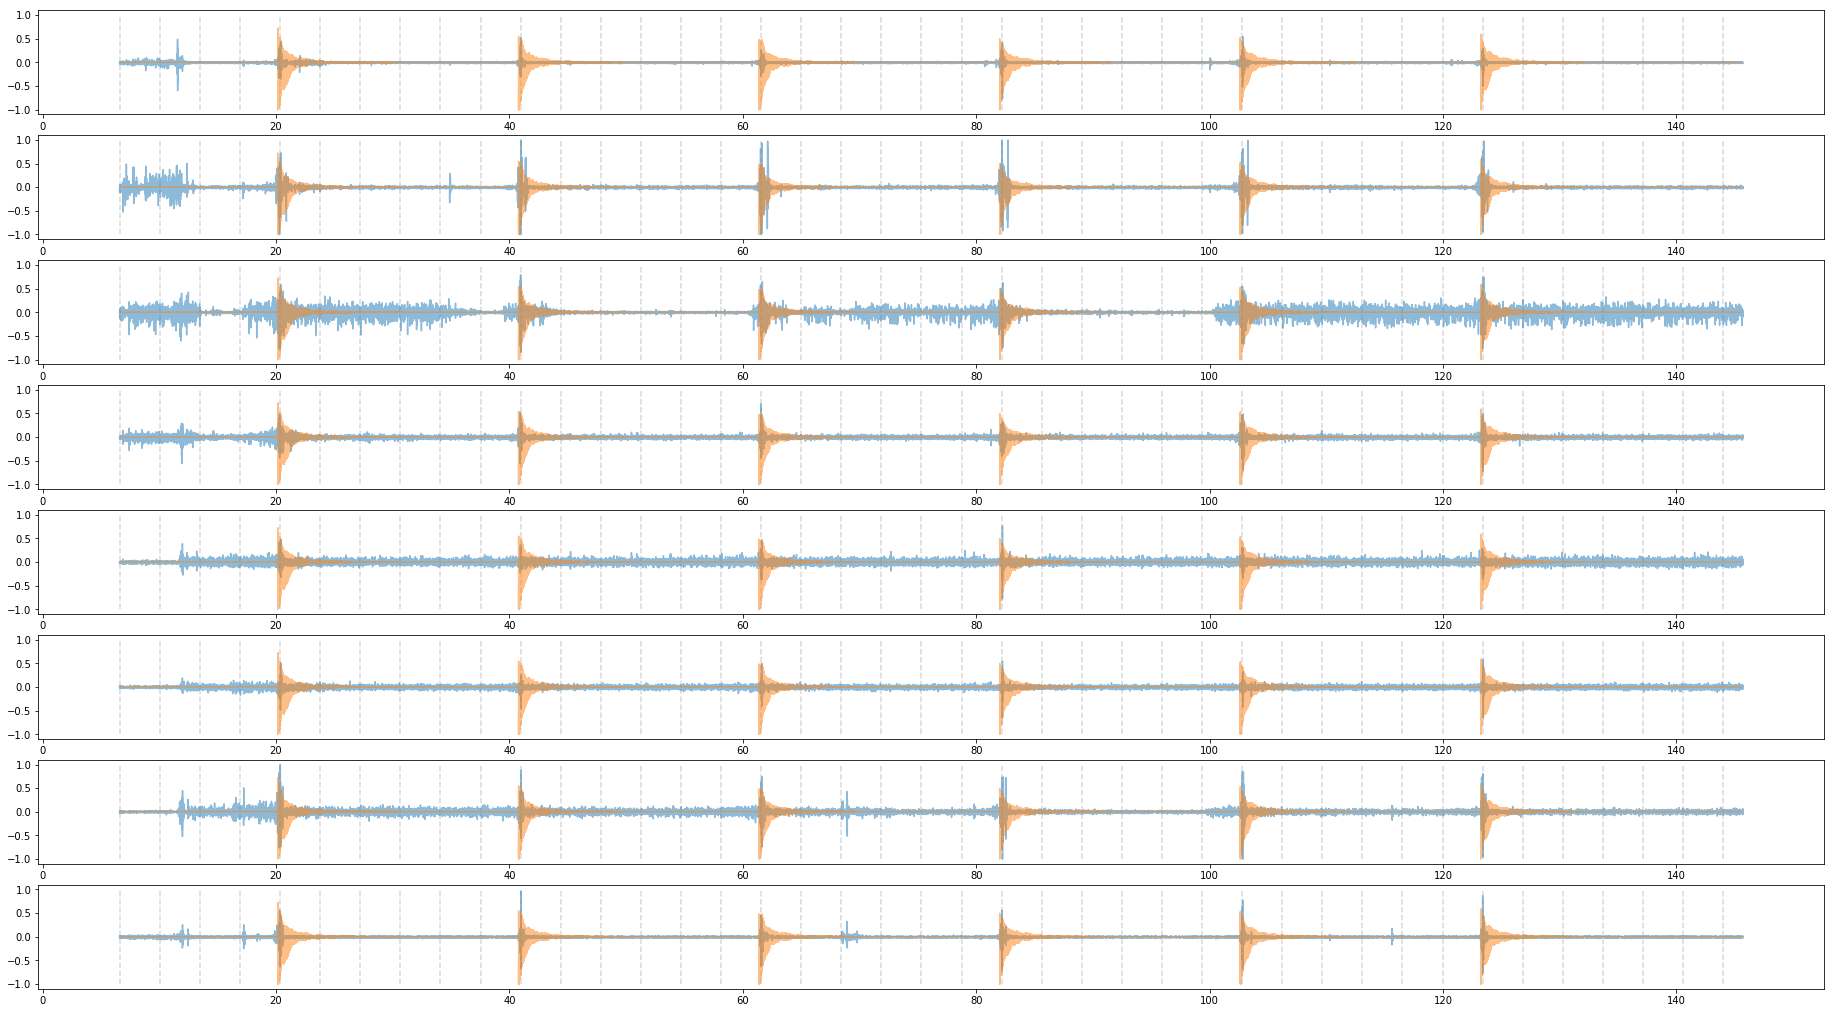

In [ ]:
plt.figure(figsize=(32,18))
plt.title('EMG(right) and sound')

for i in range(8):
    plt.subplot(8,1,i+1)
    col = "emg"+str(i+1)
    plt.plot(emg_r.index, emg_r[col], label=col, alpha=0.5)
    plt.plot(time, sound, label="sound", alpha=0.5)
    plt.vlines(metro_timeline[::4], -1, 1, colors = "grey", linestyles = "dashed", alpha=0.3)

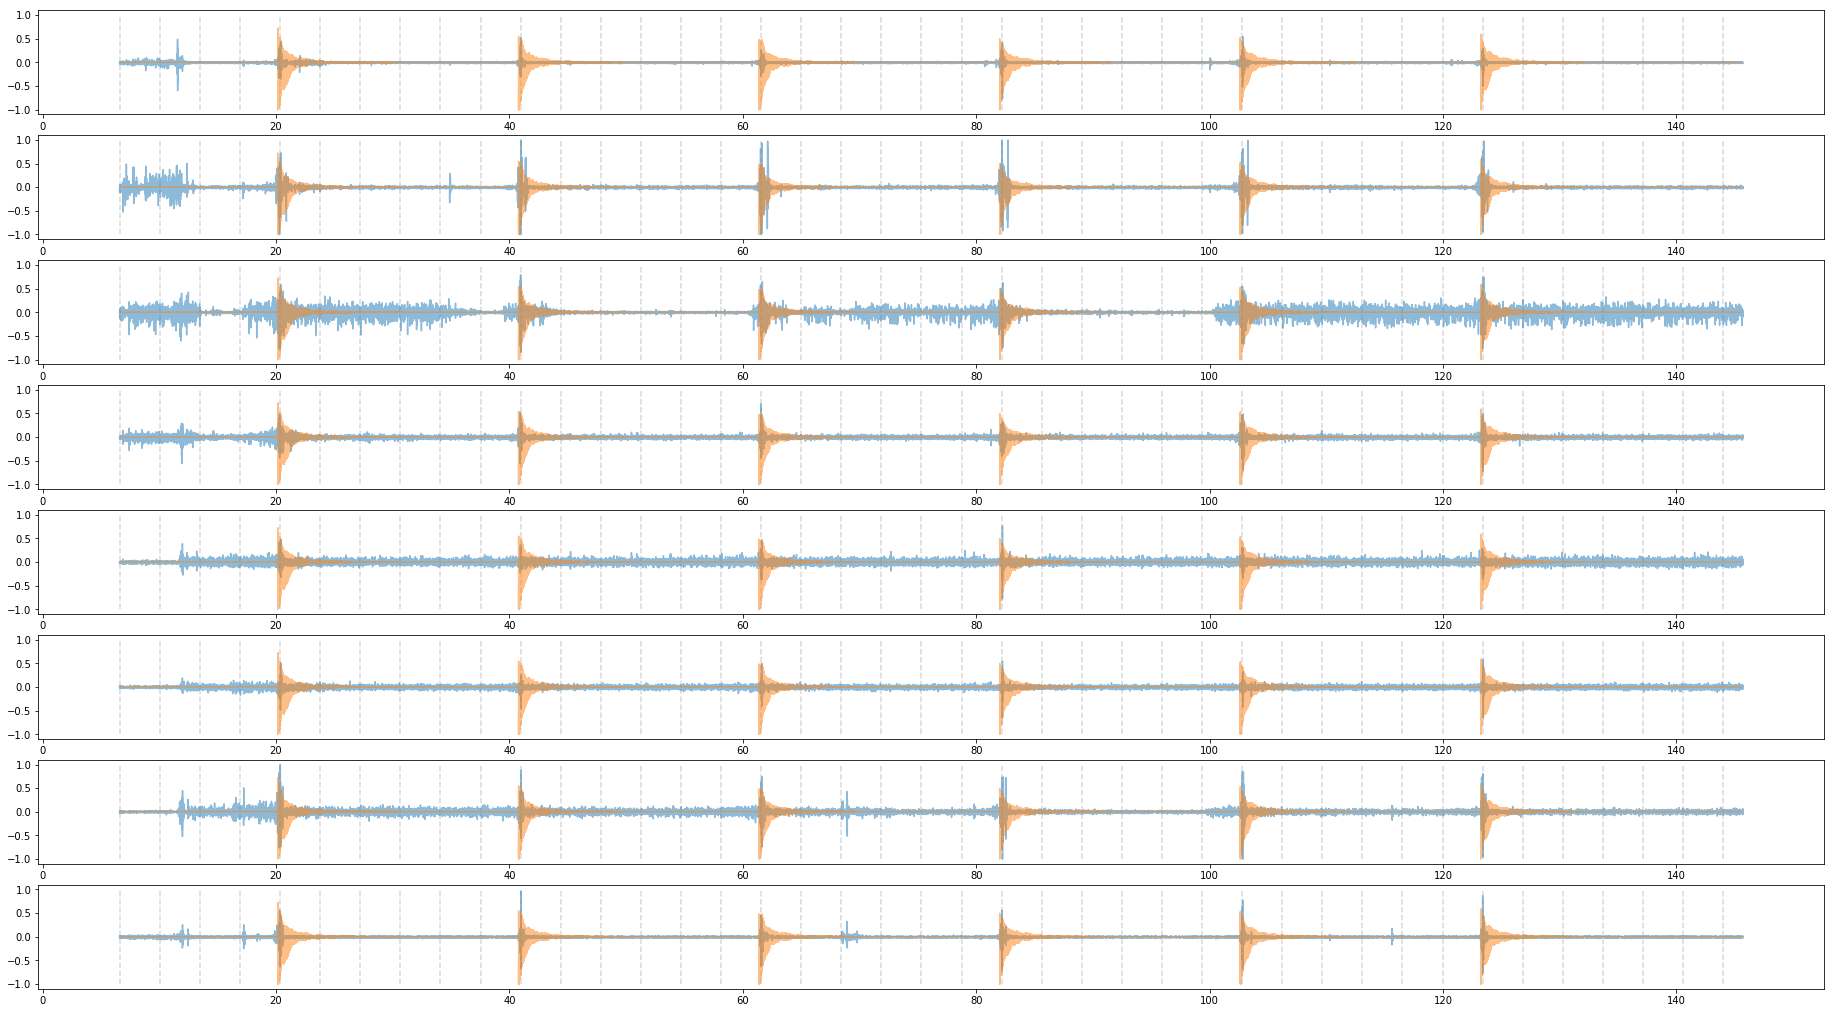

In [ ]:
plt.figure(figsize=(32,18))
plt.title('EMG(left) and sound')

for i in range(8):
    plt.subplot(8,1,i+1)
    col = "emg"+str(i+1)
    plt.plot(emg_r.index, emg_r[col], label=col, alpha=0.5)
    plt.plot(time, sound, label="sound", alpha=0.5)
    plt.vlines(metro_timeline[::4], -1, 1, colors = "grey", linestyles = "dashed", alpha=0.3)

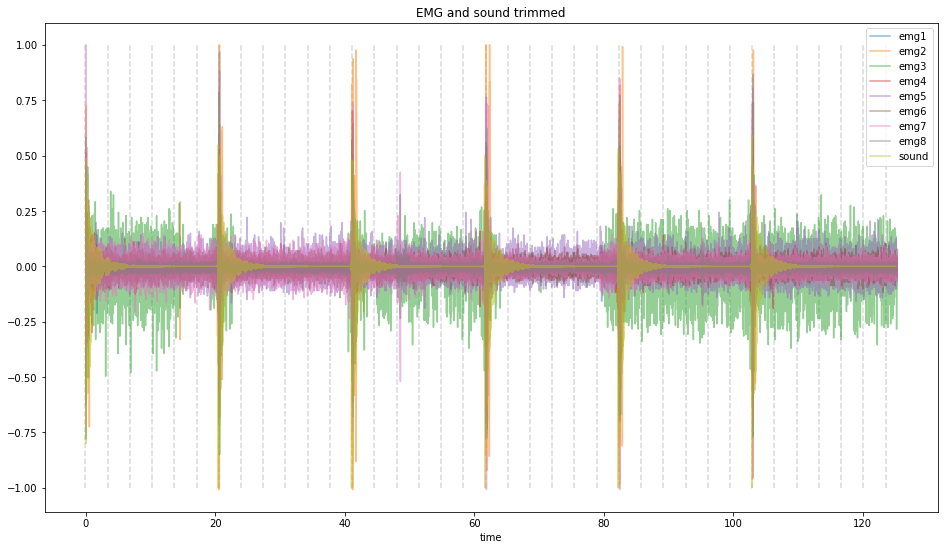

In [ ]:
# now we will have emg, sound, metro time all cut from beat N, and start from 0:00 second

cut_point = metro_timeline[16] #cut the first n number of beats

metro_timeline = [t - start for t in metro_timeline]

metro_timeline = metro_timeline[:-16]

# emg_l = emg_l[emg_r.index > cut_point]
# s = emg_l.index[0]
# emg_l.index = [t - s for t in emg_l.index]
emg_r = emg_r[emg_r.index > cut_point]
s = emg_r.index[0]
emg_r.index = [t - s for t in emg_r.index]

sound = sound[int((cut_point - start) * 48000):]
time = np.linspace(0, get_duration(sound, sr=48000), num=len(sound) )

plt.figure(figsize=(16,9))
plt.title('EMG and sound trimmed')
plt.xlabel("time")

for col in emg_r:
    plt.plot(emg_r.index, emg_r[col], label = col, alpha=0.5)
plt.plot(time, sound, label="sound", alpha=0.5)
plt.legend(loc='upper right')
plt.vlines(metro_timeline[::4], -1, 1, colors = "grey", linestyles = "dashed", alpha=0.3)

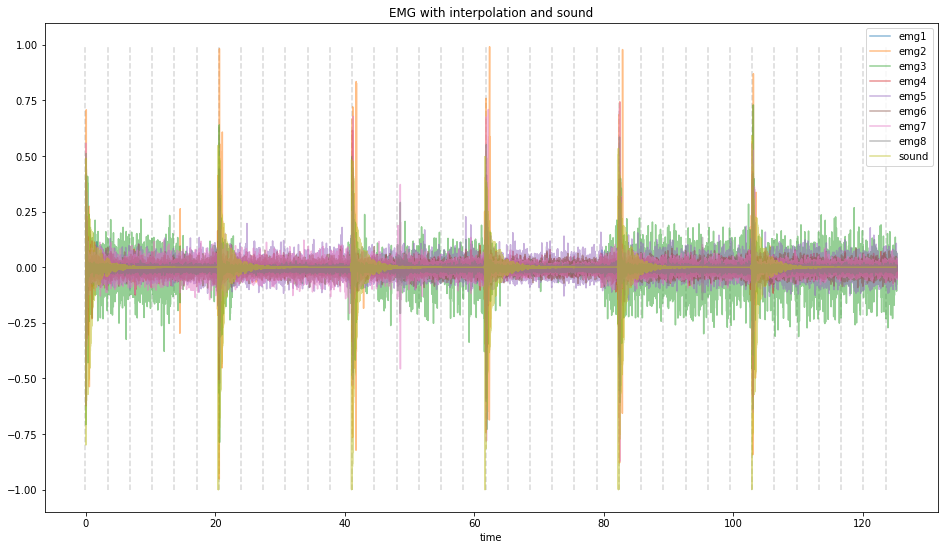

In [ ]:
# plot after interplotting the emg, almost identical

def inter(emg_df):
    x = emg_df.index

    #interpolation
    x_new = np.linspace(start=x[0], stop=x[-1], num=int((x[-1] - x[0])*200))

    emg_inter = []
    for col in emg_df.columns:
        y = emg_df[col]
        func = interpolate.interp1d(x, y)
        y_new = func(x_new)
        emg_inter.append(y_new)
    emg_inter = np.array(emg_inter).transpose()
    emg_inter = pd.DataFrame(data=emg_inter, columns=["emg"+str(i+1) for i in range(8)], index=x_new)
    return emg_inter

emg_l = inter(emg_r)
emg_r = inter(emg_r)

plt.figure(figsize=(16,9))
plt.title('EMG with interpolation and sound')
plt.xlabel("time")

for col in emg_r:
    plt.plot(emg_r.index, emg_r[col], label = col, alpha=0.5)
plt.plot(time, sound, label="sound", alpha=0.5)
plt.legend(loc='upper right')
plt.vlines(metro_timeline[::4], -1, 1, colors = "grey", linestyles = "dashed", alpha=0.3)

In [ ]:
# start to calculate the rms

# helper function
def energy_rms(y, hop_length=256, frame_length=100, sr=200):
    y = np.array(y)
    
    energy = np.array([
        np.sum((y[i:i+frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])
    
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rms_timeline = librosa.frames_to_time(range(len(rms)), sr=sr, hop_length=hop_length)
    
    return norm(energy), norm(rms), rms_timeline

data = emg_r.emg2

emg_energy, emg_rms, emg_rms_time = energy_rms(data, hop_length=1, frame_length=100, sr=200)
sound_energy, sound_rms, sound_rms_time = energy_rms(sound, hop_length=240, frame_length=24000, sr=48000)

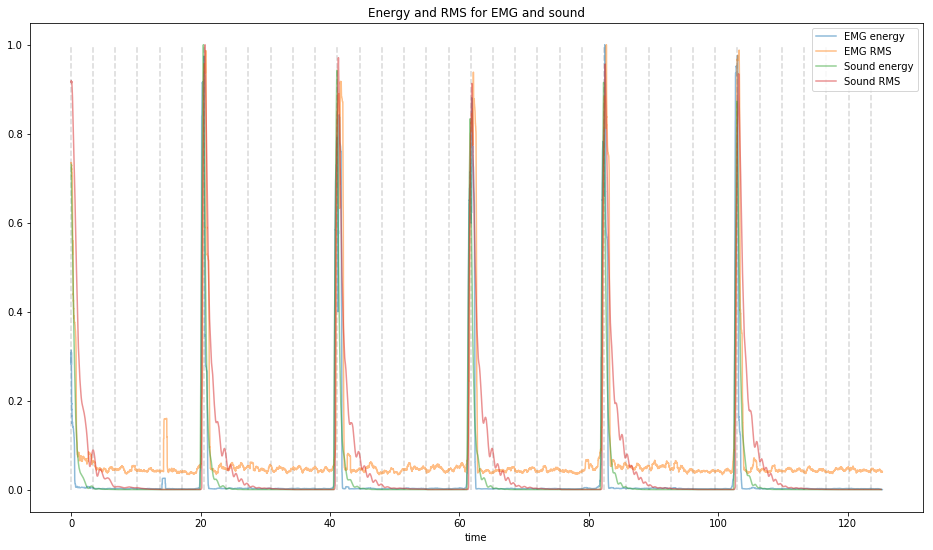

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Energy and RMS for EMG and sound')
plt.xlabel("time")

alpha = 0.5

# plt.plot(data.index, data, 'grey', alpha=0.5)
plt.plot(emg_rms_time[:-1], emg_energy, label="EMG energy", alpha=alpha)
plt.plot(emg_rms_time, emg_rms, label="EMG RMS", alpha=alpha)

plt.plot(sound_rms_time, sound_energy, label="Sound energy", alpha=alpha)
plt.plot(sound_rms_time, sound_rms, label="Sound RMS", alpha=alpha)

plt.vlines(metro_timeline[::4], 0, 1, colors = "grey", linestyles = "dashed", alpha=0.3)

plt.legend(loc='upper right')

(15, 25)

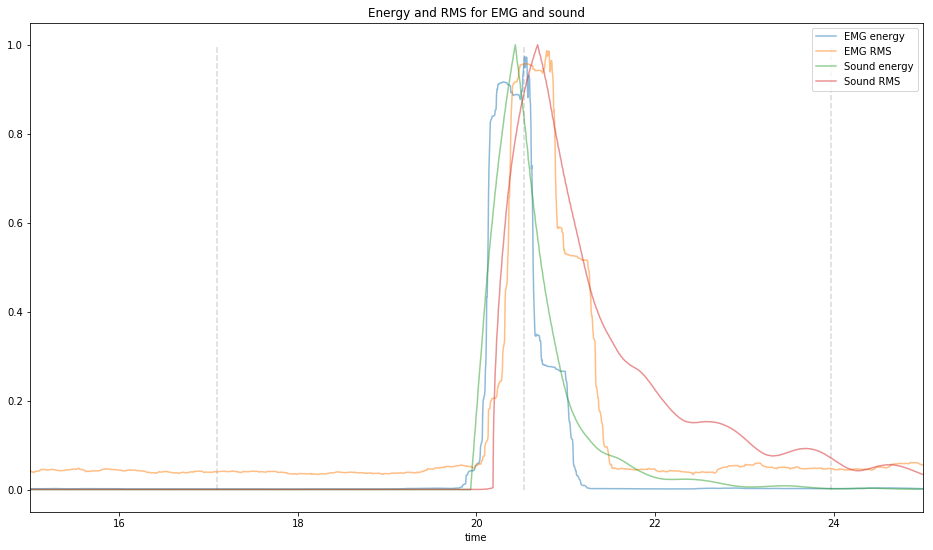

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Energy and RMS for EMG and sound')
plt.xlabel("time")

alpha = 0.5

# plt.plot(data.index, data, 'grey', alpha=0.5)
plt.plot(emg_rms_time[:-1], emg_energy, label="EMG energy", alpha=alpha)
plt.plot(emg_rms_time, emg_rms, label="EMG RMS", alpha=alpha)

plt.plot(sound_rms_time, sound_energy, label="Sound energy", alpha=alpha)
plt.plot(sound_rms_time, sound_rms, label="Sound RMS", alpha=alpha)

plt.vlines(metro_timeline[::4], 0, 1, colors = "grey", linestyles = "dashed", alpha=0.3)

plt.legend(loc='upper right')
plt.xlim(15,25)

In [ ]:
# they align pretty well
# so we can now start to trim them to every 0.5 second
# then output to npy file
# we will focus on raw emgs and the sound rms

emg = []
for col in emg_r.columns:
    y = emg_r[col].to_numpy()
    emg.append(y)
    
for col in emg_l.columns: # first right, then left
    y = emg_l[col].to_numpy()
    emg.append(y)

emg = np.array(emg)

np.save(path + 'emg_lr_raw', emg)
np.save(path + 'sound_rms', sound_rms)